# Resumen
En este notebook, se realiza una simulación para ilustrar el efecto de la regularización Ridge (L2) y Lasso (L1) en el balance entre sesgo y varianza (bias-variance tradeoff).

Para llevar a cabo el análisis, el proceso se divide en los siguientes pasos:

#### Generación de Datos Sintéticos: 
Se crea un conjunto de datos artificial donde la relación subyacente entre las características (X) y la variable objetivo (y) es lineal y conocida (y = X @ true_coeffs). Para simular condiciones realistas, se añade ruido gaussiano controlado a esta relación.

#### Proceso de Simulación: 
Se ajustan modelos Ridge y Lasso para un amplio rango de valores del coeficiente de regularización (alpha). Este proceso de ajuste se repite 100 veces, utilizando en cada iteración una nueva muestra de datos sintéticos. Este método permite simular cómo se comportarían los modelos al ser entrenados con diferentes subconjuntos de datos del "mundo real".

#### Estimación de Sesgo y Varianza: 
Utilizando las predicciones guardadas de las 100 simulaciones, se calcula el sesgo al cuadrado (qué tan lejos está la predicción promedio del valor verdadero) y la varianza (cuánto varían las predicciones entre sí).



## Generación de Datos Sintéticos

#### generamos 200 muestras de datos con 20 características. Agregamos ruido gaussiano a los datos y finalmente terminamos con datos de x e y.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,  Ridge, Lasso


# Generar datos sintéticos
np.random.seed(42) # Para reproducibilidad
true_coeffs = np.random.uniform(-10, 10, size=20) # Coeficientes verdaderos

n_samples = 200
n_features = 20
X = np.random.rand(n_samples, n_features) * 10 # Características entre 0 y 10
noise = np.random.normal(0,30, size=n_samples) # Ruido gaussiano
y = X @ true_coeffs + noise # Variable objetivo
y_true = X @ true_coeffs # Variable objetivo sin ruido

## Simulación
#### se llevan a cabo 100 simulaciones para ridge y lasso, los valores de predicción y los pesos son almacenados.


In [2]:
n_simulations = 100
alphas = np.logspace(-3, 4, 100) # en total 100 valores de alpha para Ridge y Lasso

# Almacenar resultados
all_predictions_ridge = {alpha:[] for alpha in alphas}
all_predictions_lasso = {alpha:[] for alpha in alphas}
coeffs_ridge = {alpha:[] for alpha in alphas}
coeffs_lasso = {alpha:[] for alpha in alphas}

print("iniciando simulaciones...")
for i in range(n_simulations):
    # Se generan nuevos datos con ruido en cada simulación
    X_sim = np.random.rand(n_samples, n_features) * 10
    noise_sim = np.random.normal(0, 30, size=n_samples) # ruido con media 0 y desviación estándar 20
    y_sim = X_sim @ true_coeffs + noise_sim
    # y_true_sim = X_sim @ true_coeffs # Esta línea no es estrictamente necesaria para el resto del código

    for alpha in alphas:
        # Modelo Ridge
        ridge = Ridge(alpha=alpha, max_iter=10000)
        ridge.fit(X_sim, y_sim)
        # Predecimos sobre el CONJUNTO DE REFERENCIA FIJO 'X'
        all_predictions_ridge[alpha].append(ridge.predict(X))
        coeffs_ridge[alpha].append(ridge.coef_)

        # Modelo Lasso
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_sim, y_sim)
        # Predecimos sobre el CONJUNTO DE REFERENCIA FIJO 'X'
        all_predictions_lasso[alpha].append(lasso.predict(X))
        coeffs_lasso[alpha].append(lasso.coef_)

print("simulaciones finalizadas.")

iniciando simulaciones...
simulaciones finalizadas.


## Calculo de Sesgo y Varianza
#### se calcula el sesgo y la varianza para los modelos ridge y lasso a partir de las predicciones obtenidas en la simulación anterior.

In [3]:
bias_sq_ridge, variance_ridge, mse_ridge = [], [], []
bias_sq_lasso, variance_lasso, mse_lasso = [], [], []

for alpha in alphas:
    # Para Ridge
    avg_predictions_ridge = np.mean(all_predictions_ridge[alpha], axis=0)
    bias_sq_r = np.mean((avg_predictions_ridge - y_true)**2)
    variance_r = np.mean(np.var(all_predictions_ridge[alpha], axis=0))
    mse_r = np.mean((np.array(all_predictions_ridge[alpha]) - y_true)**2) # Forma más directa de calcular MSE
    
    bias_sq_ridge.append(bias_sq_r)
    variance_ridge.append(variance_r)
    mse_ridge.append(mse_r)

    # Para Lasso
    avg_predictions_l = np.mean(all_predictions_lasso[alpha], axis=0) # Corregido
    bias_sq_l = np.mean((avg_predictions_l - y_true)**2) # Corregido
    variance_l = np.mean(np.var(all_predictions_lasso[alpha], axis=0))
    mse_l = np.mean((np.array(all_predictions_lasso[alpha]) - y_true)**2) # Forma más directa de calcular MSE

    bias_sq_lasso.append(bias_sq_l)
    variance_lasso.append(variance_l)
    mse_lasso.append(mse_l)

## visualización de Resultados
#### se crean gráficos para comparar los resultados de sesgo y varianza entre los modelos ridge y lasso.

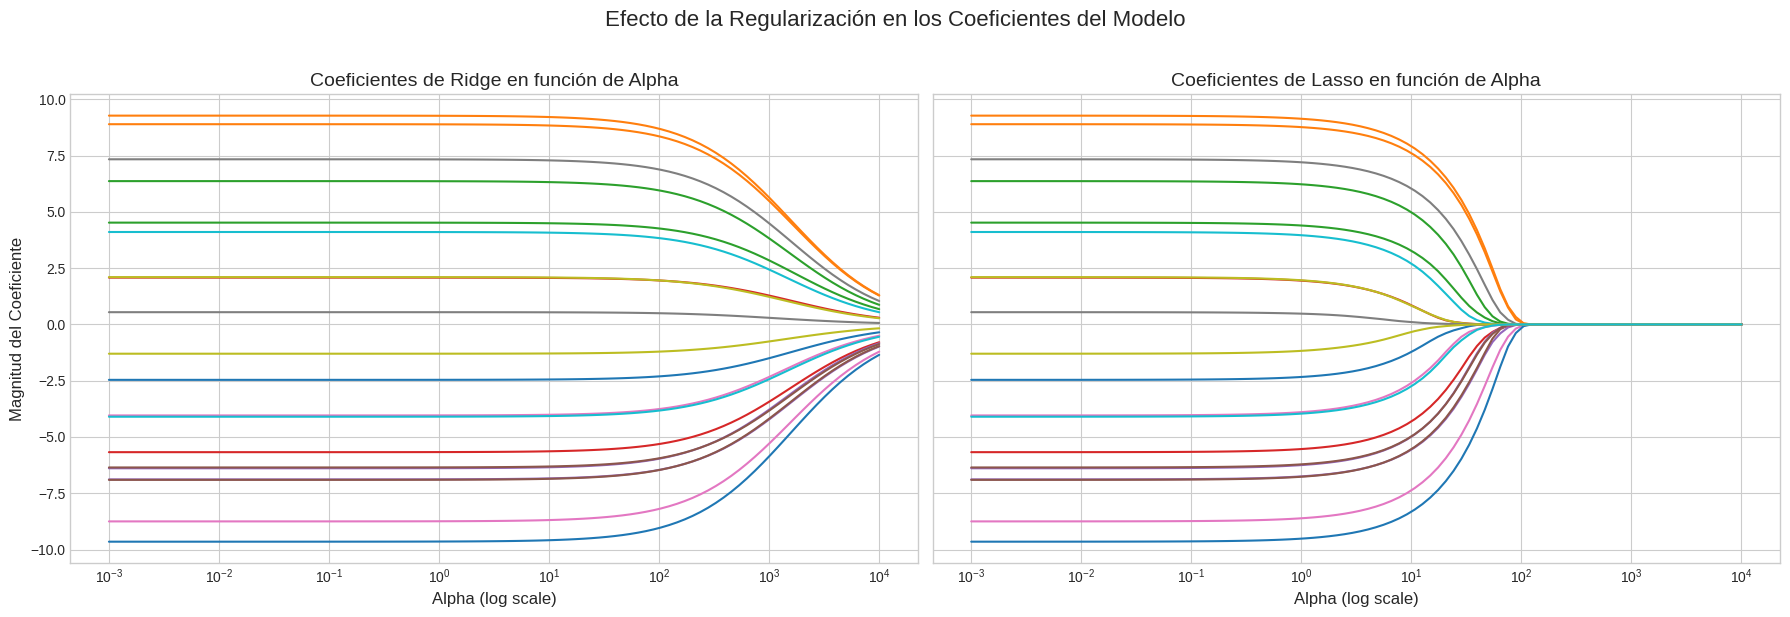

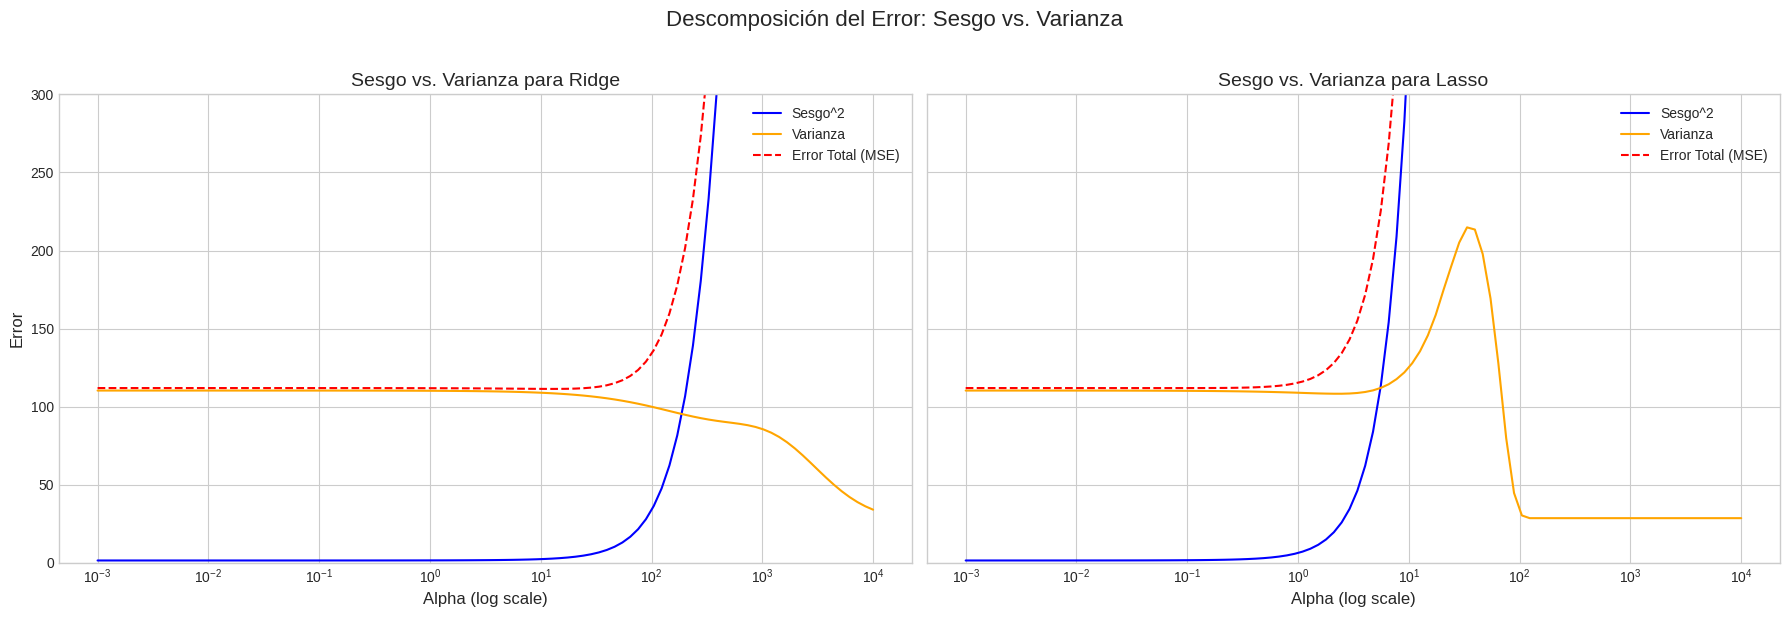

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico 1: Magnitud de los coeficientes vs. Alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Coeficientes de Ridge
avg_coeffs_r = np.array([np.mean(coeffs_ridge[alpha], axis=0) for alpha in alphas])
ax1.plot(alphas, avg_coeffs_r)
ax1.set_xscale('log')
ax1.set_title('Coeficientes de Ridge en función de Alpha', fontsize=14)
ax1.set_xlabel('Alpha (log scale)', fontsize=12)
ax1.set_ylabel('Magnitud del Coeficiente', fontsize=12)

# Coeficientes de Lasso
avg_coeffs_l = np.array([np.mean(coeffs_lasso[alpha], axis=0) for alpha in alphas])
ax2.plot(alphas, avg_coeffs_l)
ax2.set_xscale('log')
ax2.set_title('Coeficientes de Lasso en función de Alpha', fontsize=14)
ax2.set_xlabel('Alpha (log scale)', fontsize=12)

fig.suptitle('Efecto de la Regularización en los Coeficientes del Modelo', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Gráfico 2: Descomposición de Sesgo y Varianza vs. Alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Sesgo y Varianza para Ridge
ax1.plot(alphas, bias_sq_ridge, label='Sesgo^2', color='blue')
ax1.plot(alphas, variance_ridge, label='Varianza', color='orange')
ax1.plot(alphas, mse_ridge, label='Error Total (MSE)', color='red', linestyle='--')
ax1.set_xscale('log')
ax1.set_title('Sesgo vs. Varianza para Ridge', fontsize=14)
ax1.set_xlabel('Alpha (log scale)', fontsize=12)
ax1.set_ylabel('Error', fontsize=12)
ax1.legend()
ax1.set_ylim(0, 300)


# Sesgo y Varianza para Lasso
ax2.plot(alphas, bias_sq_lasso, label='Sesgo^2', color='blue')
ax2.plot(alphas, variance_lasso, label='Varianza', color='orange')
ax2.plot(alphas, mse_lasso, label='Error Total (MSE)', color='red', linestyle='--')
ax2.set_xscale('log')
ax2.set_title('Sesgo vs. Varianza para Lasso', fontsize=14)
ax2.set_xlabel('Alpha (log scale)', fontsize=12)
ax2.legend()
ax2.set_ylim(0, 300)
#ax2.set_xlim(1e-1, 1e2)

fig.suptitle('Descomposición del Error: Sesgo vs. Varianza', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Resultados

El primer gráfico muestra cómo la magnitud de los coeficientes de los modelos se reduce a medida que aumenta alpha (coeficiente de regularización), demostrando el efecto de contracción de la regularización.

Para el caso de Regularización Lasso podemos notar cómo los valores de los coeficioentes son llevados a cero a medida que aumenta alpha, lo que indica que Lasso realiza selección de características al eliminar algunas variables del modelo.

Ahora para el caso de Regularización Ridge vemos que los coeficientes también disminuyen, pero nunca llegan a ser iguales a cero, lo que indica que Ridge no realiza selección de características, sino que simplemente reduce la magnitud de todos los coeficientes.

En el segundo gráfico se visualiza la relación entre el sesgo, la varianza y el error total en función del coeficiente de regularización. Este gráfico ilustra claramente que al aumentar alpha, la varianza del modelo disminuye mientras que el sesgo tiende a aumentar, permitiendo encontrar un punto óptimo que minimiza el error general.

iniciando simulaciones...
simulaciones finalizadas.


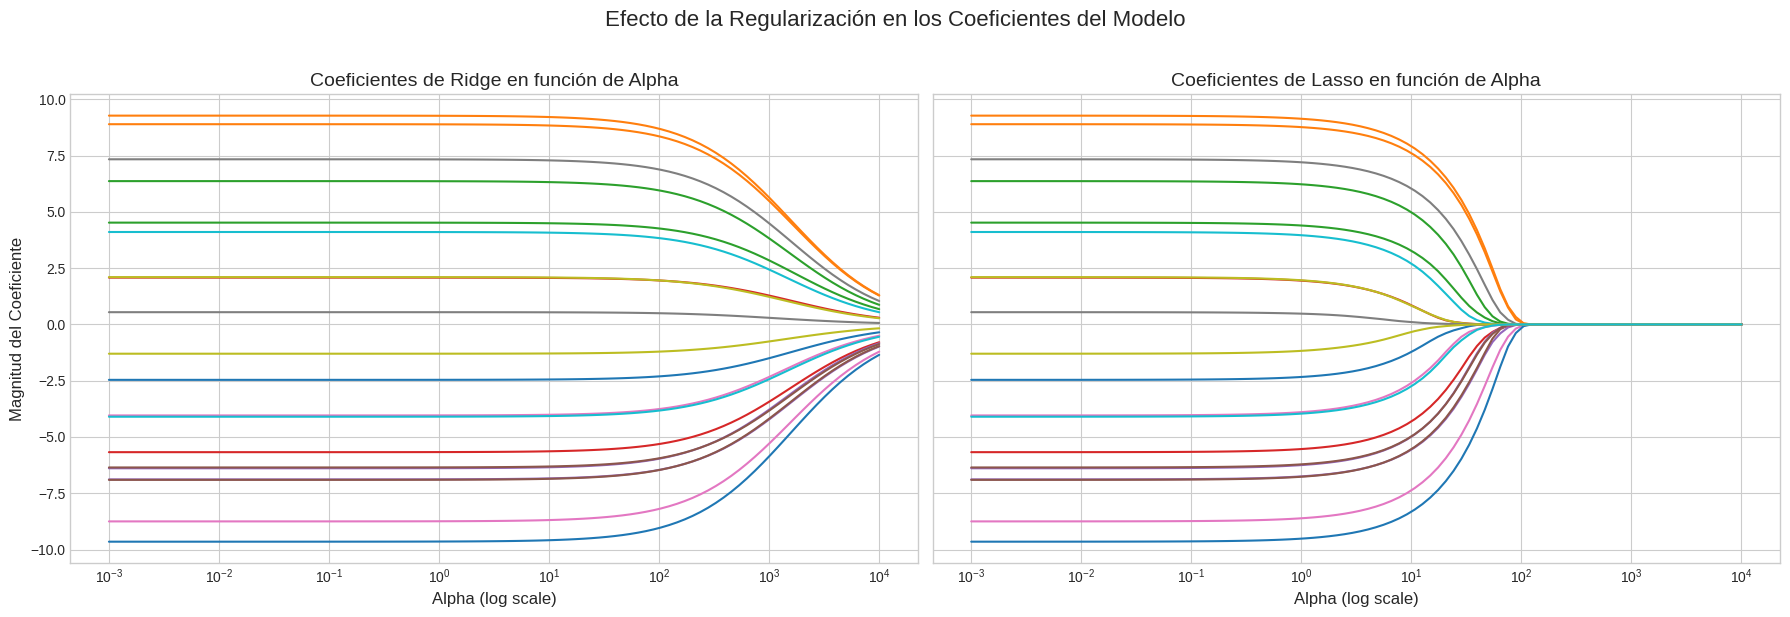

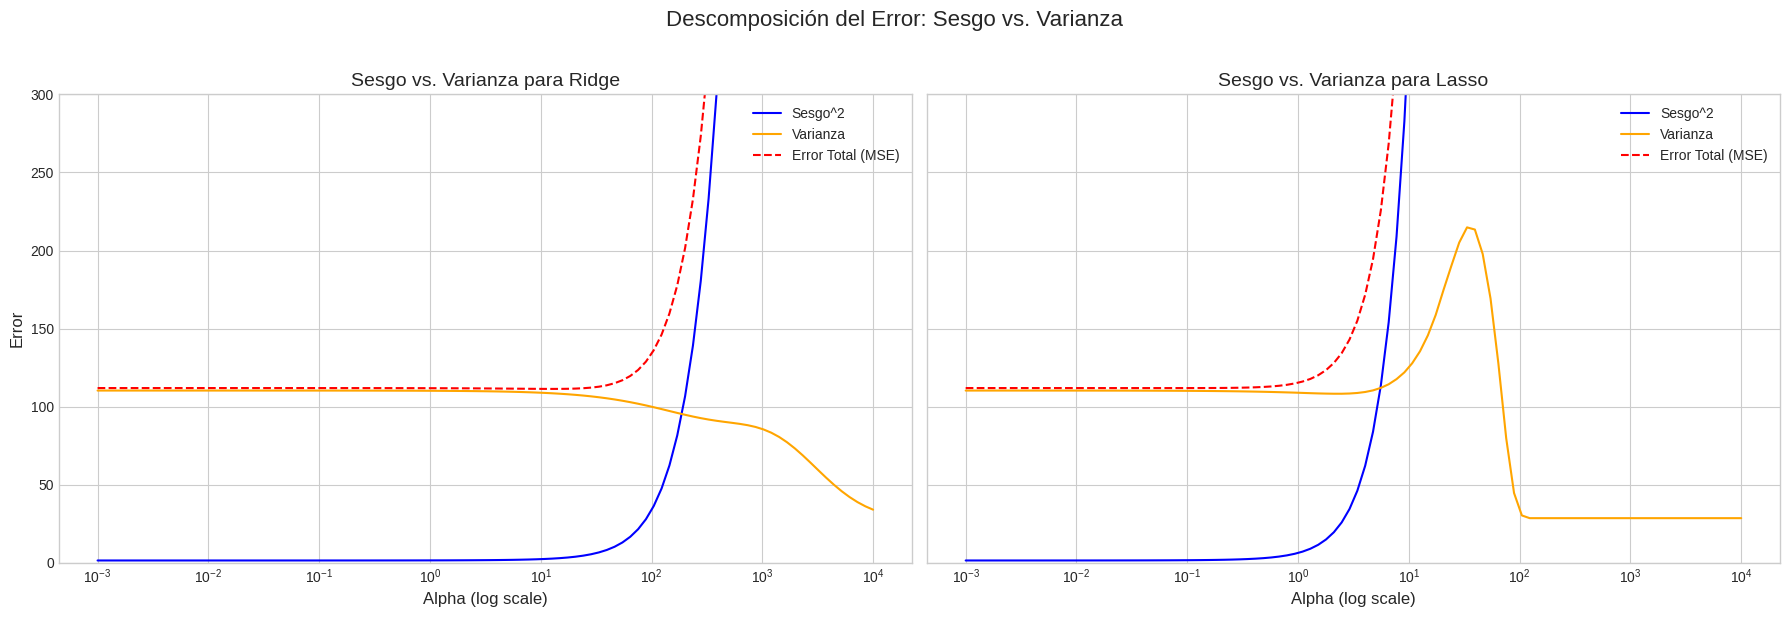

In [5]:
# CELDA 1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,  Ridge, Lasso


# Generar datos sintéticos
np.random.seed(42) # Para reproducibilidad
true_coeffs = np.random.uniform(-10, 10, size=20) # Coeficientes verdaderos
#true_coeffs[5:15] = 0 # Hacer los primeros 10 coeficientes cero

n_samples = 200
n_features = 20
X = np.random.rand(n_samples, n_features) * 10 # Características entre 0 y 10
noise = np.random.normal(0,30, size=n_samples) # Ruido gaussiano
y = X @ true_coeffs + noise # Variable objetivo
y_true = X @ true_coeffs # Variable objetivo sin ruido


# --------------------------------------------------

# CELDA 2
n_simulations = 100
alphas = np.logspace(-3, 4, 100) # en total 100 valores de alpha para Ridge y Lasso

# Almacenar resultados
all_predictions_ridge = {alpha:[] for alpha in alphas}
all_predictions_lasso = {alpha:[] for alpha in alphas}
coeffs_ridge = {alpha:[] for alpha in alphas}
coeffs_lasso = {alpha:[] for alpha in alphas}

print("iniciando simulaciones...")
for i in range(n_simulations):
    # Se generan nuevos datos con ruido en cada simulación
    X_sim = np.random.rand(n_samples, n_features) * 10
    noise_sim = np.random.normal(0, 30, size=n_samples) # ruido con media 0 y desviación estándar 20
    y_sim = X_sim @ true_coeffs + noise_sim
    # y_true_sim = X_sim @ true_coeffs # Esta línea no es estrictamente necesaria para el resto del código

    for alpha in alphas:
        # Modelo Ridge
        ridge = Ridge(alpha=alpha, max_iter=10000)
        ridge.fit(X_sim, y_sim)
        # Predecimos sobre el CONJUNTO DE REFERENCIA FIJO 'X'
        all_predictions_ridge[alpha].append(ridge.predict(X))
        coeffs_ridge[alpha].append(ridge.coef_)

        # Modelo Lasso
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_sim, y_sim)
        # Predecimos sobre el CONJUNTO DE REFERENCIA FIJO 'X'
        all_predictions_lasso[alpha].append(lasso.predict(X))
        coeffs_lasso[alpha].append(lasso.coef_)

print("simulaciones finalizadas.")

# -----------------------------------------------------------------

# CELDA 3
bias_sq_ridge, variance_ridge, mse_ridge = [], [], []
bias_sq_lasso, variance_lasso, mse_lasso = [], [], []

for alpha in alphas:
    # Para Ridge
    avg_predictions_ridge = np.mean(all_predictions_ridge[alpha], axis=0)
    bias_sq_r = np.mean((avg_predictions_ridge - y_true)**2)
    variance_r = np.mean(np.var(all_predictions_ridge[alpha], axis=0))
    mse_r = np.mean((np.array(all_predictions_ridge[alpha]) - y_true)**2) # Forma más directa de calcular MSE
    
    bias_sq_ridge.append(bias_sq_r)
    variance_ridge.append(variance_r)
    mse_ridge.append(mse_r)

    # Para Lasso
    avg_predictions_l = np.mean(all_predictions_lasso[alpha], axis=0) # Corregido
    bias_sq_l = np.mean((avg_predictions_l - y_true)**2) # Corregido
    variance_l = np.mean(np.var(all_predictions_lasso[alpha], axis=0))
    mse_l = np.mean((np.array(all_predictions_lasso[alpha]) - y_true)**2) # Forma más directa de calcular MSE

    bias_sq_lasso.append(bias_sq_l)
    variance_lasso.append(variance_l)
    mse_lasso.append(mse_l)
# --------------------------------------------------


# CELDA 4

plt.style.use('seaborn-v0_8-whitegrid')

# Gráfico 1: Magnitud de los coeficientes vs. Alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Coeficientes de Ridge
avg_coeffs_r = np.array([np.mean(coeffs_ridge[alpha], axis=0) for alpha in alphas])
ax1.plot(alphas, avg_coeffs_r)
ax1.set_xscale('log')
ax1.set_title('Coeficientes de Ridge en función de Alpha', fontsize=14)
ax1.set_xlabel('Alpha (log scale)', fontsize=12)
ax1.set_ylabel('Magnitud del Coeficiente', fontsize=12)

# Coeficientes de Lasso
avg_coeffs_l = np.array([np.mean(coeffs_lasso[alpha], axis=0) for alpha in alphas])
ax2.plot(alphas, avg_coeffs_l)
ax2.set_xscale('log')
ax2.set_title('Coeficientes de Lasso en función de Alpha', fontsize=14)
ax2.set_xlabel('Alpha (log scale)', fontsize=12)

fig.suptitle('Efecto de la Regularización en los Coeficientes del Modelo', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Gráfico 2: Descomposición de Sesgo y Varianza vs. Alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Sesgo y Varianza para Ridge
ax1.plot(alphas, bias_sq_ridge, label='Sesgo^2', color='blue')
ax1.plot(alphas, variance_ridge, label='Varianza', color='orange')
ax1.plot(alphas, mse_ridge, label='Error Total (MSE)', color='red', linestyle='--')
ax1.set_xscale('log')
ax1.set_title('Sesgo vs. Varianza para Ridge', fontsize=14)
ax1.set_xlabel('Alpha (log scale)', fontsize=12)
ax1.set_ylabel('Error', fontsize=12)
ax1.legend()
ax1.set_ylim(0, 300)


# Sesgo y Varianza para Lasso
ax2.plot(alphas, bias_sq_lasso, label='Sesgo^2', color='blue')
ax2.plot(alphas, variance_lasso, label='Varianza', color='orange')
ax2.plot(alphas, mse_lasso, label='Error Total (MSE)', color='red', linestyle='--')
ax2.set_xscale('log')
ax2.set_title('Sesgo vs. Varianza para Lasso', fontsize=14)
ax2.set_xlabel('Alpha (log scale)', fontsize=12)
ax2.legend()
ax2.set_ylim(0, 300)
#ax2.set_xlim(1e-1, 1e2)

fig.suptitle('Descomposición del Error: Sesgo vs. Varianza', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------